# PA 2
## Author: Khodosevich Leonid

***at first PA I got -2 points for comments, this time I tried to comment all untrivial moments***

# Task 1: Kernelized SVM

In this task you will work with the “digits” data set [4]. Load the training and testing  
data (sklearn.datasets.load_digits). Split the dataset to use 70 % of the data for  
training and 30 % of the data for testing. Use an SVM (sklearn.svm.SVC) for classification. For evaluation, we will consider the accuracy (sklearn.metrics.accuracy_score)  
and confusion matrices (to be implemented by you).  

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore")


# setting seed for replicability
SEED = 42
np.random.seed(SEED)

## Subtask 1: SVMs With Different Kernels

(10 points)  
Evaluate a support vector machine (using default parameters except for the kernel) on the dataset,   
using different kernels (linear, poly, rbf, sigmoid).  
Select good hyperparam- eters for the kernels using model selection techniques.  
- Report the classification accuracies on the training and test set and how much model   
selection improved performance. Also report your hyperparameters and how you selected them.  


In [2]:
# data loading and splitting
df = datasets.load_digits()
X = df.data
y = df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (1257, 64)
y_train shape: (1257,)
X_test shape: (540, 64)
y_test shape: (540,)


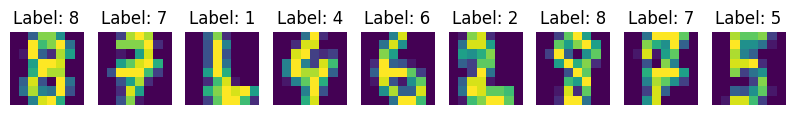

In [3]:
# plot data. Dont really need to do this here, but I believe its nice thing to do in any case
fig, axs = plt.subplots(1, 9, figsize=(10, 10))
for i, ax in enumerate(axs):
    ax.imshow(X_train[i].reshape(8, 8))
    ax.set_title(f'Label: {y_train[i]}')
    ax.axis('off')
plt.show()

In [4]:
# Task: Evaluate a support vector machine (using default parameters except for the kernel) 
# on the dataset, using different kernels (linear, poly, rbf, sigmoid).
kernel_names = ['linear', 'poly', 'rbf', 'sigmoid']
result_accuracy_test = []  
for ker in kernel_names:
    svm = SVC(kernel=ker, random_state=SEED)
    svm.fit(X_train, y_train)
    y_pred_train = svm.predict(X_train)
    y_pred_test = svm.predict(X_test)
    result_accuracy_test.append(accuracy_score(y_test, y_pred_test))
    print(
        f"Model with kernel {ker} has train accuracy of {accuracy_score(y_train, y_pred_train):.2%}"
        )
    print(
        f"Model with kernel {ker} has test accuracy of {accuracy_score(y_test, y_pred_test):.2%}\n"
        )
best_accuracy_idx = np.argmax(result_accuracy_test)
best_accuracy = result_accuracy_test[best_accuracy_idx]
kernel_name = kernel_names[best_accuracy_idx]
print(f"best accuracy is {best_accuracy:.2%} for kernel {kernel_name}")

Model with kernel linear has train accuracy of 100.00%
Model with kernel linear has test accuracy of 97.96%

Model with kernel poly has train accuracy of 99.92%
Model with kernel poly has test accuracy of 98.89%

Model with kernel rbf has train accuracy of 99.68%
Model with kernel rbf has test accuracy of 98.70%

Model with kernel sigmoid has train accuracy of 91.96%
Model with kernel sigmoid has test accuracy of 90.74%

best accuracy is 98.89% for kernel poly


In [5]:
# Task: Select good hyperparameters for the kernels using model selection techniques.  
# Report the classification accuracies on the training and test set and how much model   
# selection improved performance. Also report your hyperparameters and how you selected them.  

# classifier's best parameters will be chosen with grid search cross validation
# Idea is thakt we have grid of parameters and function produces cross validation score 
# for each parameter combination therefore obtaining best parameters
parameters = {
    'kernel': ('linear', 'poly', 'rbf', 'sigmoid'), # kernel type
    'gamma': ["scale", 1e-4, 1e-5, 1e-3], # in sklearn doc changing to 1e-3 improve accuracy
    "tol": [1e-1, 1e-2, 1e-3], # tolerance for stopping criterion
    'degree': [3, 4, 5, 6, 7, 9], # for poly kernel, other will ignore it
    'C': [1, 8, 9, 10, 11, 12] # regularization parameter
    }

# now we find best classifier
svm = SVC(random_state=SEED)
gs = GridSearchCV(
    svm, parameters, cv=5, n_jobs=-1, verbose=1, scoring='accuracy'
    )
gs.fit(X_train, y_train)
GS_estimator = gs.best_estimator_
y_pred_train = GS_estimator.predict(X_train)
y_pred_test = GS_estimator.predict(X_test)
# reporting everything specified in task
print(f"Best svm parameters: {gs.best_params_} with CV score {gs.best_score_:.2%}")
print(
    f"Best model train accuracy of {accuracy_score(y_train, y_pred_train):.2%}"
    )
print(
    f"Best with kernel {ker} has test accuracy of {accuracy_score(y_test, y_pred_test):.2%}\n"
    )
print(f"accuracy improved by {accuracy_score(y_test, y_pred_test) - best_accuracy:.2%}")
grid_search_best_result = accuracy_score(y_test, y_pred_test)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


Best svm parameters: {'C': 8, 'degree': 3, 'gamma': 0.001, 'kernel': 'rbf', 'tol': 0.1} with CV score 99.21%
Best model train accuracy of 100.00%
Best with kernel sigmoid has test accuracy of 99.07%

accuracy improved by 0.19%


## Subtask 2: Develop Your Own Kernel
(20 points)  
Develop a custom kernel that achieves higher accuracy as compared to your results from the previous subtask (see [1]) for an example of how to do this).  
- Describe your kernel and the idea behind your kernel.  
- Proof/argue that you actually implemented a valid kernel.  
- If you fail to achieve higher accuracy, describe what you tried/thought about.  
Hint: familiarize yourself with the classification task; in particular, the meaning of the features.

In [6]:
# here will be all kernels that I tried
# taken from sklearn documentation
def custom_kernel(X, Y):
    return X @ Y.T

# we have images so we have to somrhow find a kernel that would devide them all 
# Idea: use a kernel that would give more weight to the center of the image -> gaussian kernel
# but instead of just gaussian kernel we will use a gaussian kernel with a weight 
# on the center of the image
# 
# motivation on this and some theoretical background could be found here:
# https://core.ac.uk/download/pdf/190973863.pdf
def build_custom_kernel(center_weight, gamma, central_range): 
    # have to put params to kernel function, solution was here:
    # https://datascience.stackexchange.com/questions/22416/passing-a-custom-
    # kernel-with-more-than-two-arguments-into-svm-svc-in-scikit-le
    def custom_kernel(X, Y):
        weights = np.ones(X.shape[1])
        center_index = X.shape[1] // 2
        weights[center_index-central_range:center_index+central_range] = center_weight 
        P = np.diag(weights)
        distances = euclidean_distances(X @ P, Y @ P)
        return np.exp(-gamma * distances ** 2)

    return custom_kernel

# we create an instance of SVM and fit out data.
# I will only change center weight as different gammas were bad before
cr_list = []
cw_list = []
test_res = []
for central_range in np.arange(1, 10, 1):
    for center_weight in np.arange(1, 2, 0.1):
        # building model and predictiong for train and test
        custom_kernel_svm = SVC(
            kernel=build_custom_kernel(
                center_weight=center_weight, gamma=1e-3, central_range=central_range
            ), 
            random_state=SEED, 
            C=1
            )
        custom_kernel_svm.fit(X_train, y_train)
        y_pred_train = custom_kernel_svm.predict(X_train)
        y_pred_test = custom_kernel_svm.predict(X_test)
        # saving results for DataFrame, as its easier to look at
        cr_list.append(central_range)
        cw_list.append(center_weight)
        test_res.append(accuracy_score(y_test, y_pred_test))
res = pd.DataFrame(
    {
        'center_range': cr_list,
        'center_weight': cw_list,
        'test_accuracy': test_res
    }
)

In [7]:
# selecting all rows where we've achieved better result than the grid 
# search one and selecting best params
best_custom_kernel_model_params = list((
    res
    .query("test_accuracy > @grid_search_best_result")
    .iloc[0][["center_range", "center_weight"]]
))
res.query("test_accuracy > @grid_search_best_result")

,center_range,center_weight,test_accuracy
43,5,1.3,0.992593
44,5,1.4,0.992593


In [8]:
# finding how much % we won from customizing kernel
print(f"best result: {res.test_accuracy.max():.2%} "\
    + f"which is {res.test_accuracy.max() - grid_search_best_result:.2%} better than GSCV")

best result: 99.26% which is 0.19% better than GSCV


- as we can see, central weight 1.3 and 1.4 with central range 5 slightly improves the results to 99.26%, which is 0.19% better than the grid search result.

## Subtask 3: Classifier Evaluation I
(10 points)  
Evaluate the best classifiers from the previous two tasks in more detail (the best SVM with a kernel available in scikit-learn and the SVM with   your own kernel). In particular, implement a function to compute and print the confusion matrix for the classifiers.  
Don’t use scikit’s functions for this purpose but rather implement this functionality yourself.  
- Report your obtained confusion matrix.
- Do you see any structure in the confusion matrix? If so, report what you observe. If
not, state so.
- Compute the classification accuracies of the classifiers from the confusion matrix. Report your computation and result.

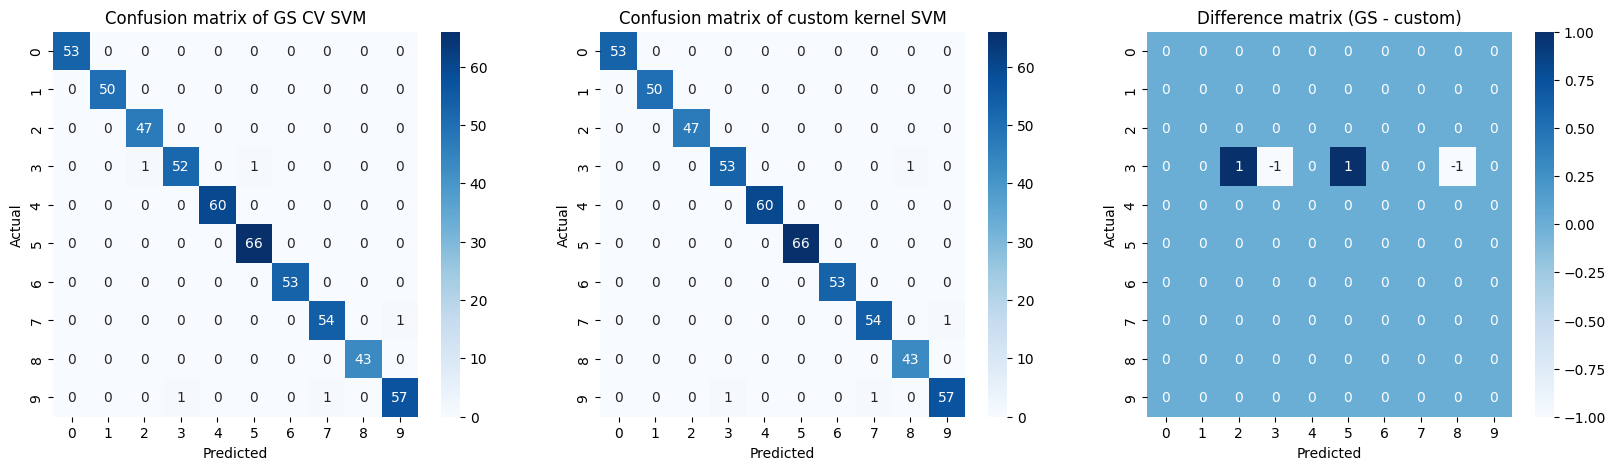

In [9]:
# In particular, implement a function to compute and print the confusion matrix for the classifiers.  
# Don’t use scikit’s functions for this purpose but rather implement this functionality yourself.  
# In order to better understand the confusion matrix, I visualize it with heatmap from seaborn.

# Idea of realization: pd.crosstab computes frequency of 
# appearence of each pair of values in two arrays, 
# which is exactly what we need from confusion matrix.


def make_confision_matrix(y_true, y_pred):
    return pd.crosstab(y_true, y_pred)

# retrain model with best params
center_weight = best_custom_kernel_model_params[1]
central_range = int(best_custom_kernel_model_params[0])

custom_kernel_svm = SVC(
    kernel=build_custom_kernel(
        center_weight=center_weight, gamma=1e-3, central_range=central_range
    ), 
    random_state=SEED, 
    C=1
)
custom_kernel_svm.fit(X_train, y_train)

cm_GS_estimator = make_confision_matrix(y_test, GS_estimator.predict(X_test))
cm_custom_estimator = make_confision_matrix(y_test, custom_kernel_svm.predict(X_test))

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.heatmap(
    cm_GS_estimator, 
    annot=True, fmt='d', cmap='Blues', ax=ax[0]
    )
ax[0].set_title('Confusion matrix of GS CV SVM')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
sns.heatmap(
    cm_custom_estimator, 
    annot=True, fmt='d', cmap='Blues', ax=ax[1]
    )
ax[1].set_title('Confusion matrix of custom kernel SVM')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

sns.heatmap(
    cm_GS_estimator - cm_custom_estimator,
    annot=True, fmt='d', cmap='Blues', ax=ax[2]
    )
ax[2].set_title('Difference matrix (GS - custom)')
ax[2].set_xlabel('Predicted')
ax[2].set_ylabel('Actual')
plt.show()

- We can see, that the most confusing digit for model is 3, model confuses it with 2, 5 for GS and 8 for custom kernel model. Probably this is because some 3's and 8's in this dataset are written the way that they are really similar.
- After applying custom kernel, model predicted one more 3 right, which made accuracy go up.

In [10]:
# I dont know what is ment by "accuracy" in the task, 
# so I will compute accuracy as the ratio of correct predictions to the total number of predictions.
# As well as accuracies of each class.

def compute_accuracy_from_cm(cm):
    return np.trace(cm) / np.concat(cm_GS_estimator).sum()

def comute_per_class_accuracy(cm):
    res = pd.Series(np.diag(cm) / cm_GS_estimator.sum(axis=1))
    res.index = cm_GS_estimator.index
    res = res.round(3)
    return res

print(f"accuracy of GC model: {compute_accuracy_from_cm(cm_GS_estimator):.2%}")
print(f"accuracy of custom model: {compute_accuracy_from_cm(cm_custom_estimator):.2%}")

print(f"Per class accuracy of GC model:\n{comute_per_class_accuracy(cm_GS_estimator)}")
print(f"Per class accuracy of custom model:\n{comute_per_class_accuracy(cm_custom_estimator)}")

accuracy of GC model: 99.07%
accuracy of custom model: 99.26%
Per class accuracy of GC model:
row_0
0    1.000
1    1.000
2    1.000
3    0.963
4    1.000
5    1.000
6    1.000
7    0.982
8    1.000
9    0.966
dtype: float64
Per class accuracy of custom model:
row_0
0    1.000
1    1.000
2    1.000
3    0.981
4    1.000
5    1.000
6    1.000
7    0.982
8    1.000
9    0.966
dtype: float64


- Again, we can see, that accuracy grew up in third class. 

# Task 2: Feature Selection

In this task you will use the breast cancer dataset [3].   
Load the data and normalize it using the MinMaxScaler.   
Split the data into 70% training data and 30% test data (shuffle the data beforehand!).   
As the classification model use the sklearn.svm.LinearSVC with the default parameters.  

In [11]:
# loading data for task
# setting shuffle=True to do shuffle from task
df = datasets.load_breast_cancer()
X = df.data
y = df.target
names = df.feature_names
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED, shuffle=True
    )
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Train set: (398, 30)
Test set: (171, 30)


## Subtask 1: Forward Greedy Feature Selection
Implement forward greedy feature selection wrt the 10-fold cross-validation performance.
- Report the order of the features (including their names) for forward greedy feature selection. Also record and report the performance of models for each of the number of features.  



Algo:  
  

- Start with $S=\emptyset$ and $E_0=\infty$
- For $i=1,2, \ldots, d$ :
- find best element to add: $s_i=\operatorname{argmin}_{j \in \mathcal{V} \backslash S} \hat{L}(S \cup\{j\})$
- compute error: $E_i=\hat{L}\left(S \cup\left\{s_i\right\}\right)$
- If $E_i>E_{i-1}$ break, else set $S \leftarrow S \cup\left\{s_i\right\}$

  
**!!! In this excercise, as no specific loss function was given, I will use default metric of cross_val_score (accuracy)**


In [12]:
# There is not much to explain here, I just implemented steps, specified in algorithm
# The only difference is that algo uses loss function, which should decrease with adding new feature
# But in this case, I use accuracy, which should increase -> break condition is changed

def finding_smallest_each_step_fw(model, X_train, y_train, S, log_step):
    """Does s_i = argmin L(S+{j}) step by adding one of features, counting score and returning best
    """
    max_val_score = -np.inf
    S_upd_best = S.copy()
    for j in range(X_train.shape[1]):
        if  j in S:
            continue
        S_upd = S + [j]
        X_train_upd = X_train[:, S_upd]
        score = cross_val_score(model, X_train_upd, y_train, cv=10).mean()
        if log_step:
            print(f"step {j} score {score}, S {S_upd}")
        if score > max_val_score:
            max_val_score = score
            S_upd_best = S_upd
    return S_upd_best, max_val_score


def forward_greedy_feature_selection(model, X_train, y_train, max_features=None, log_step=False):
    """Perform forward greedy feature selection with algorythm described in lecture
    """
    S = []
    best_achieved_score = -np.inf
    logs = {"added": [], "features": [], "score": []}
    for i in tqdm(range(X_train.shape[1])):
        if (max_features is not None) and (len(S) >= max_features):
            print("REached max features")
            break
        # find best feature set for step
        S_upd_best, max_val_score = finding_smallest_each_step_fw(
            model, X_train, y_train, S, log_step
            )
        # if improved -> next step, else break
        if max_val_score > best_achieved_score:
            logs["added"].append([el for el in S_upd_best if el not in S][0])
            logs["features"].append(S_upd_best)
            logs["score"].append(max_val_score)
            S = S_upd_best
            best_achieved_score = max_val_score
        else:
            break
    return S, best_achieved_score, logs

def get_names(S):
    return [str(names[i]) for i in S]

In [13]:
model = LinearSVC()
S, best_achieved_score, logs = forward_greedy_feature_selection(model, X_train, y_train)

 17%|█▋        | 5/30 [00:00<00:03,  6.70it/s]


In [14]:
print(f"final set of features: {S}")
print(f"final set of features: {get_names(S)}")
print(f"Achieved accuracy with that set: {best_achieved_score:.2%}")
print(f"DataFrame of seature selection:")
pd.DataFrame(logs)

final set of features: [7, 21, 20, 26, 11]
final set of features: ['mean concave points', 'worst texture', 'worst radius', 'worst concavity', 'texture error']
Achieved accuracy with that set: 97.48%
DataFrame of seature selection:


,added,features,score
0,7,[7],0.907115
1,21,"[7, 21]",0.937244
2,20,"[7, 21, 20]",0.964808
3,26,"[7, 21, 20, 26]",0.969744
4,11,"[7, 21, 20, 26, 11]",0.974808


## Subtask 2: Backward Greedy Feature Selection
(11 points)  
- Report the order of the features (including their names) for backward greedy feature selection. Also record and report the performance of models for each of the number of features.

In [15]:
# There is not much to explain here, I just implemented steps, specified in algorithm
# The only difference is that algo uses loss function, 
# which should decrease with removing new feature
# But in this case, I use accuracy, which should increase -> break condition is changed

def finding_smallest_each_step_bw(model, X_train, y_train, S, log_step):
    """Does s_i = argmin L(S\{j}) step, by removing each feature from S, 
    computing score and returning best one
    """
    max_val_score = -np.inf
    S_upd_best = S.copy()
    for j in S:
        S_upd = [el for el in S if el != j]
        X_train_upd = X_train[:, S_upd]
        score = cross_val_score(model, X_train_upd, y_train, cv=10).mean()
        if log_step:
            print(f"Step {j}: {score}, S_upd: {S_upd}")
        if score > max_val_score:
            max_val_score = score
            S_upd_best = S_upd
    return S_upd_best, max_val_score


def backward_greedy_feature_selection(model, X_train, y_train, max_features=None, log_step=False):
    """Perform backward greedy feature selection with algorythm described in lecture
    """
    S = list(range(X_train.shape[1]))
    best_achieved_score = -np.inf
    logs = {"dropped": [], "features": [], "score": []}
    for i in tqdm(range(X_train.shape[1])):
        # find best feature set for step
        S_upd_best, max_val_score = finding_smallest_each_step_bw(
            model, X_train, y_train, S, log_step
            )
        # if we havent reached max features, or score is better than best achieved -> next step
        # else -> break
        if ((max_features is not None) and (len(S) > max_features)) \
            or (max_val_score >= best_achieved_score):
            logs["dropped"].append([el for el in S if el not in S_upd_best][0])
            logs["features"].append(S_upd_best)
            logs["score"].append(max_val_score)
            S = S_upd_best
            best_achieved_score = max_val_score
        else:
            break
    return S, best_achieved_score, logs

In [16]:
model = LinearSVC()
S, best_achieved_score, logs = backward_greedy_feature_selection(model, X_train, y_train)

 60%|██████    | 18/30 [00:02<00:01,  7.79it/s]


In [17]:
print(f"final set of features: {S}")
print(f"final set of features: {get_names(S)}")
print(f"Achieved accuracy with that set: {best_achieved_score:.2%}")
print(f"DataFrame of seature selection:")
pd.DataFrame(logs)

final set of features: [1, 7, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29]
final set of features: ['mean texture', 'mean concave points', 'fractal dimension error', 'worst radius', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']
Achieved accuracy with that set: 98.00%
DataFrame of seature selection:


,dropped,features,score
0,18,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.977436
1,21,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.977500
2,5,"[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.980000
3,0,"[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",0.980000
4,2,"[1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...",0.980000
5,3,"[1, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",0.980000
6,4,"[1, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...",0.980000
7,6,"[1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...",0.980000
8,8,"[1, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, ...",0.980000
9,10,"[1, 7, 9, 11, 12, 13, 14, 15, 16, 17, 19, 20, ...",0.980000


# Subtask 3: Feature Importance
(4 points)
Assume that you are only allowed to use 6 out of the 30 features for classification. 
- Which features would you select using forward and backward feature selection? 
- Do the features differ and if so, why?

---
Answer:
- In order to implement this restriction, for each function I added a  max_feature parameter.
- For forward_selection it constraints number of selected features by breaking from loop when cap is met
- For backwars_selection it continues loop even if score is dropping, which is implemented in if statement

In [18]:
model = LinearSVC()
S, best_achieved_score, logs = forward_greedy_feature_selection(model, X_train, y_train, max_features=6)

 17%|█▋        | 5/30 [00:00<00:03,  6.99it/s]


In [19]:
print(f"final set of features: {S}")
print(f"final set of features: {get_names(S)}")
print(f"Achieved accuracy with that set: {best_achieved_score:.2%}")
print(f"DataFrame of seature selection:")
pd.DataFrame(logs)

final set of features: [7, 21, 20, 26, 11]
final set of features: ['mean concave points', 'worst texture', 'worst radius', 'worst concavity', 'texture error']
Achieved accuracy with that set: 97.48%
DataFrame of seature selection:


,added,features,score
0,7,[7],0.907115
1,21,"[7, 21]",0.937244
2,20,"[7, 21, 20]",0.964808
3,26,"[7, 21, 20, 26]",0.969744
4,11,"[7, 21, 20, 26, 11]",0.974808


In [20]:
model = LinearSVC()
S, best_achieved_score, logs = backward_greedy_feature_selection(model, X_train, y_train, max_features=6)

 80%|████████  | 24/30 [00:02<00:00,  9.42it/s]


In [21]:
print(f"final set of features: {S}")
print(f"final set of features: {get_names(S)}")
print(f"Achieved accuracy with that set: {best_achieved_score:.2%}")
print(f"DataFrame of seature selection:")
pd.DataFrame(logs)

final set of features: [1, 20, 24, 26, 27, 29]
final set of features: ['mean texture', 'worst radius', 'worst smoothness', 'worst concavity', 'worst concave points', 'worst fractal dimension']
Achieved accuracy with that set: 96.99%
DataFrame of seature selection:


,dropped,features,score
0,18,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.977436
1,21,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.977500
2,5,"[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.980000
3,0,"[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",0.980000
4,2,"[1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...",0.980000
5,3,"[1, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",0.980000
6,4,"[1, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...",0.980000
7,6,"[1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...",0.980000
8,8,"[1, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, ...",0.980000
9,10,"[1, 7, 9, 11, 12, 13, 14, 15, 16, 17, 19, 20, ...",0.980000


- Obviously, I would take forward selection for this task, as it yields higher accuracy with less time to find required features.
- As we can see from computations before, backward selection would be better accuracy-wise, if max_features was at least 13
- this is a nice example of effect, described in the lecture, backward selection can process dependent features, while forward selection is ussually faster.